# 高斯

### 多元高斯分布

$$p(x)=\frac{1}{(2\pi)^(\frac{1}{2}){\left | \Sigma \right |}^{\frac{1}{2}}}e^{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)}$$

其中$\mu$是$n$维均值向量，$\Sigma$是$n\times n$的协方差矩阵，高斯分布由$\mu$和协方差矩阵$\Sigma$确定

### 高斯混合分布

$$p_{\mathcal{M}}=\sum_{i=1}^k\alpha_i \cdot p(x|\mu_i,\Sigma_i)$$

分布由$k$个混合组成，每个混合对应一个高斯分布，第$i$个高斯混合成分的参数是$\mu_i, \Sigma_i$，上式满足的约束$\sum_{i=1}^k\alpha_i=1,\alpha_i>0$

### 高斯混合分布的参数更新

![avart](../img/高斯混合分布算法流程图.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
path = "../dataset/cluster.dat"
dataset = np.loadtxt(path)

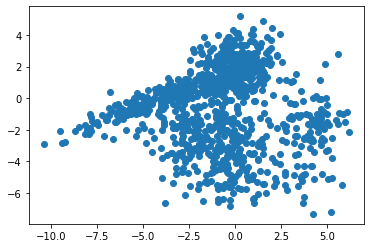

In [3]:
x = dataset[:,0]
y = dataset[:,1]
plt.scatter(x,y)

In [79]:
class GaussCluster:
    def __init__(self, K, epoch=50):
        """
        聚类个数，迭代次数
        """
        self.k = K
        self.epoch = epoch
        # 随机初始化 alpha，mu，Sigma
        self.n = None
        self.m = None
        self.gauss_parameters = [(1/K, None, None) for i in range(self.k)]
        self.cluster = None
    def train(self, train_data):
#         print(self.gauss_parameters)
        self.m, self.n = train_data.shape
        mu = random.sample(list(train_data), self.k) # 随机k个
        self.cluster = [[] for i in range(self.k)]
        self.gauss_parameters = [[1/self.k, mu[i], np.eye(self.n)] for i in range(self.k)]
        # 开始训练部分
        for epoch in range(self.epoch):
            # 计算x_j由各混合成分生成的后验概率
            # 由于容易出现矩阵的不可逆现象，所以使用try
            parameters_i_less = self.gauss_parameters
            try:
                gamma_ji = []
                for j in range(self.m):
                    p_i = np.zeros((self.k,))
                    p_M = 0
                    for i in range(self.k) :
                        p_i[i] = self.gauss_parameters[i][0] * self.gauss_distribute(train_data[j], 
                                self.gauss_parameters[i][1], self.gauss_parameters[i][2])
                        p_M += self.gauss_parameters[i][0] * self.gauss_distribute(train_data[j], 
                                self.gauss_parameters[i][1], self.gauss_parameters[i][2])
                    gamma_ji.append(p_i/p_M)
                gamma_ji = np.array(gamma_ji) # 使用numpy能够比较快完成计算

                for i in range(self.k):
                    # mu 更新
                    self.gauss_parameters[i][1] = (np.array(
                        np.sum(gamma_ji[:,i:i+1]*train_data, axis=0, keepdims=True))[0])/np.sum(
                        gamma_ji[:,i:i+1], axis=0, keepdims=True)
                    # sigma 更新
                    # 不支持teosor的操作，没办法快速运算
                    for j in range(self.m):
                        # n*1 *1 *n
                        new_sigma += gamma_ji[j][i] * (np.mat(train_data[j]-self.gauss_parameters[i][1]).T) * (
                            np.mat(train_data[j]-self.gauss_parameters[i][1]))
                    self.gauss_parameters[i][2] = new_sigma/np.sum(gamma_ji[:,i:i+1])

                    self.gauss_parameters[i][0] = np.sum(gamma_ji[:,i:i+1])/self.m
            except:
                # 捕获了异常
                self.gauss_parameters = parameters_i_less
                break
            else:
                pass
        # 完成聚类
        gamma_ji = []
        for j in range(self.m):
            p_i = np.zeros((self.k,))
            p_M = 0
            for i in range(self.k) :
                p_i[i] = self.gauss_parameters[i][0] * self.gauss_distribute(train_data[j], 
                        self.gauss_parameters[i][1], self.gauss_parameters[i][2])
                p_M += self.gauss_parameters[i][0] * self.gauss_distribute(train_data[j], 
                        self.gauss_parameters[i][1], self.gauss_parameters[i][2])
            gamma_ji.append(p_i/p_M)
        gamma_ji = np.array(gamma_ji) # 使用numpy能够比较快完成计算
        argmax = np.argmax(gamma_ji, axis=1)
        for j in range(self.m):
            self.cluster[argmax[j]].append(train_data[j])
    
    def gauss_distribute(self, x, mu, sigma):
        return (1/(2*np.pi)**(x.shape[0]/2)*np.sum(sigma)**0.5)*(np.e**(np.array((-0.5*np.mat(x-mu)*np.linalg.inv(np.mat(sigma))*np.mat(x-mu).T))[0][0]))
    
    def fit(self, x):
        m = x.shape[0]
        gamma_ji = []
        for j in range(m):
            p_i = np.zeros((self.k,))
            p_M = 0
            for i in range(self.k) :
                p_i[i] = self.gauss_parameters[i][0] * self.gauss_distribute(train_data[j], 
                        self.gauss_parameters[i][1], self.gauss_parameters[i][2])
                p_M += self.gauss_parameters[i][0] * self.gauss_distribute(train_data[j], 
                        self.gauss_parameters[i][1], self.gauss_parameters[i][2])
            gamma_ji.append(p_i/p_M)
        
        gamma_ji = np.array(gamma_ji) # 使用numpy能够比较快完成计算
        argmax = np.argmax(gamma_ji, axis=1)
        return argmax
        
            
        


In [109]:
test = GaussCluster(5,10)
test.train(dataset)

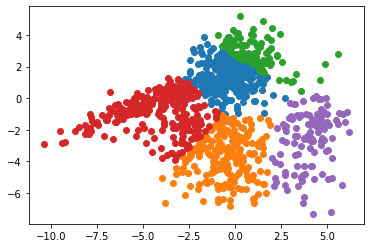

In [110]:
for x_i in test.cluster:
    cluster_i = np.array(x_i)
    x, y = cluster_i[:,0], cluster_i[:,1]
    plt.scatter(x,y)       